# Python version - Supermodel - Nutrient Pulses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Included N_pulse as a param

In [2]:
def dNdt(H, P, PH, N, parameters_dict):
    # Unpacking parameters
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    theta_H = parameters_dict['theta_H']
    c = parameters_dict['c']
    d = parameters_dict['d']
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']
    m_H = parameters_dict['m_H']
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b = parameters_dict['b']
    theta_P = parameters_dict['theta_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']
    m_P = parameters_dict['m_P']
    v_m = parameters_dict['v_m']
    k_s = parameters_dict['k_s']
    m_ph = parameters_dict['m_ph']
    y = parameters_dict['y']
    r_m = parameters_dict['r_m']
    kg = parameters_dict['kg']
    N_pulse = parameters_dict['N_pulse']


    # Calculate derivatives
    dH = r_H * H * (1 - H / K_H) + ((1 - y) * r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH))) * H) * (1 - H / K_H) - (
                c * H * P) / (d + H) + theta_H - (q_H * E_H * H) - (m_H * H)
    dP = r_P * P * (1 - P / K_P) + (b * H * P) / (d + H) + theta_P - q_P * E_P * P - m_P * P
    dPH = ((v_m * N * PH) / (k_s + N)) - (m_ph * PH) - ((r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H)
    dN = -(PH * (v_m * N) / (k_s + N)) + (0.5 * m_ph * PH) + (0.5 * m_H * H) + (1 * y * (r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H) + (
                0.5 * m_P * P)

    return dH, dP, dPH, dN

In [3]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, PH, N, parameters_dict):
    H_init = H
    P_init = P
    PH_init = PH 
    N_init = N 
    
    dH1, dP1, dPH1, dN1 = dNdt(H, P, PH, N, parameters_dict)
    
    H1 = H + 0.5 * dH1 #* dt
    P1 = P + 0.5 * dP1 #* dt
    PH1 = PH + 0.5 * dPH1 #* dt
    N1 = N + 0.5 * dN1 #* dt
    
    dH2, dP2, dPH2, dN2 = dNdt(H1, P1, PH1, N1, parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2
    dPH_ave = (dPH1+dPH2)/2
    dN_ave = (dN1+dN2)/2
    
    H = (H_init + dH_ave) #* dt #(include as another param)
    P = (P_init + dP_ave) #* dt
    PH = (PH_init + dPH_ave) #* dt 
    N = (N_init + dN_ave) #* dt
    
    if H < 0:
        H = 0 
        
    if P < 0:
        P = 0 
    
    if PH < 0:
        PH = 0 
        
    if N < 0:
        N = 0
        
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    #Calculate grazing 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    
    grazing = r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H
    
    return H, P, PH, N, herbivore_harvest, predator_harvest, grazing

In [4]:

def run_model(INIT_H, INIT_P, INIT_PH, INIT_N, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    PH_array = np.zeros(numyears+1)
    N_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    grazing_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore
    P_array[0] = INIT_P #Starting biomass of predator 
    PH_array[0] = INIT_PH #Starting biomass of phytoplankton
    N_array[0] = INIT_N #Starting biomass of nutrients
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    grazing_array[0] = 0
  
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], PH_array[i+1], N_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1], grazing_array[i+1], \
            = RK2(H_array[i], P_array[i], PH_array[i], N_array[i], parameters_dict)
        
        # Check if it's time to add a pulse of nutrients
        if (i + 1) % 30 == 0:
            N_pulse = parameters_dict['N_pulse']  # Define the magnitude of the nutrient pulse
            N_array[i + 1] += N_pulse  # Add the nutrient pulse
        
    
    return H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array

In [5]:
numyears = 36500 # number of years to run simulation

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 50 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.4/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.1/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.1/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.4/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.01/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = 0.03 # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
N_pulse = 1.0
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }

In [6]:
numyears = 36500 # number of years to run simulation 

H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

Text(0, 0.5, 'Nutrients Biomass')

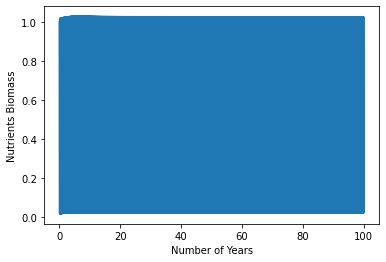

In [7]:
# Calculate the number of years in the simulation
numyears = parameters_dict['numyears']
years = numyears / 365

# Generate x-values representing years
time_years = np.linspace(0, years, len(H_array))

plt.plot(time_years, N_array)
plt.xlabel('Number of Years')
plt.ylabel('Nutrients Biomass')

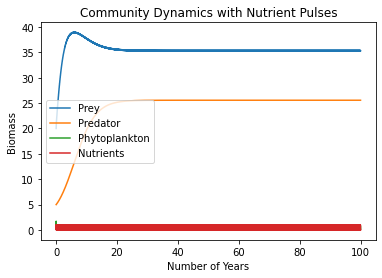

In [8]:
plt.plot(time_years, H_array, label="Prey")
plt.plot(time_years, P_array, label = "Predator")
plt.plot(time_years, PH_array, label= "Phytoplankton")
plt.plot(time_years, N_array, label= "Nutrients")
plt.legend()
plt.xlabel('Number of Years')
plt.ylabel('Biomass')
plt.title('Community Dynamics with Nutrient Pulses')

plt.show()

## Define Default Params Generalist

In [9]:
def default_generalist_params():
    numyears = 36500 # number of years to run simulation

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 50 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.2/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = (0.0/365) # Effort for herbivore harvest
    m_H = (0.1/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.1/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.2/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = (0.0/365) # Effort for predator harvest
    m_P = (0.01/365) # Predator mortality

    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = 0.03 # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    N_pulse = 1.0
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }
    
    return parameters_dict

## Define Default Params Specialist

In [10]:
def default_specialist_params():
    numyears = 36500 # number of years to run simulation

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 50 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.8/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = (0.0/365) # Effort for herbivore harvest
    m_H = (0.1/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.1/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.8/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = (0.0/365) # Effort for predator harvest
    m_P = (0.01/365) # Predator mortality

    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = 0.03 # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    N_pulse = 1.0
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }
    
    return parameters_dict

# Section 3

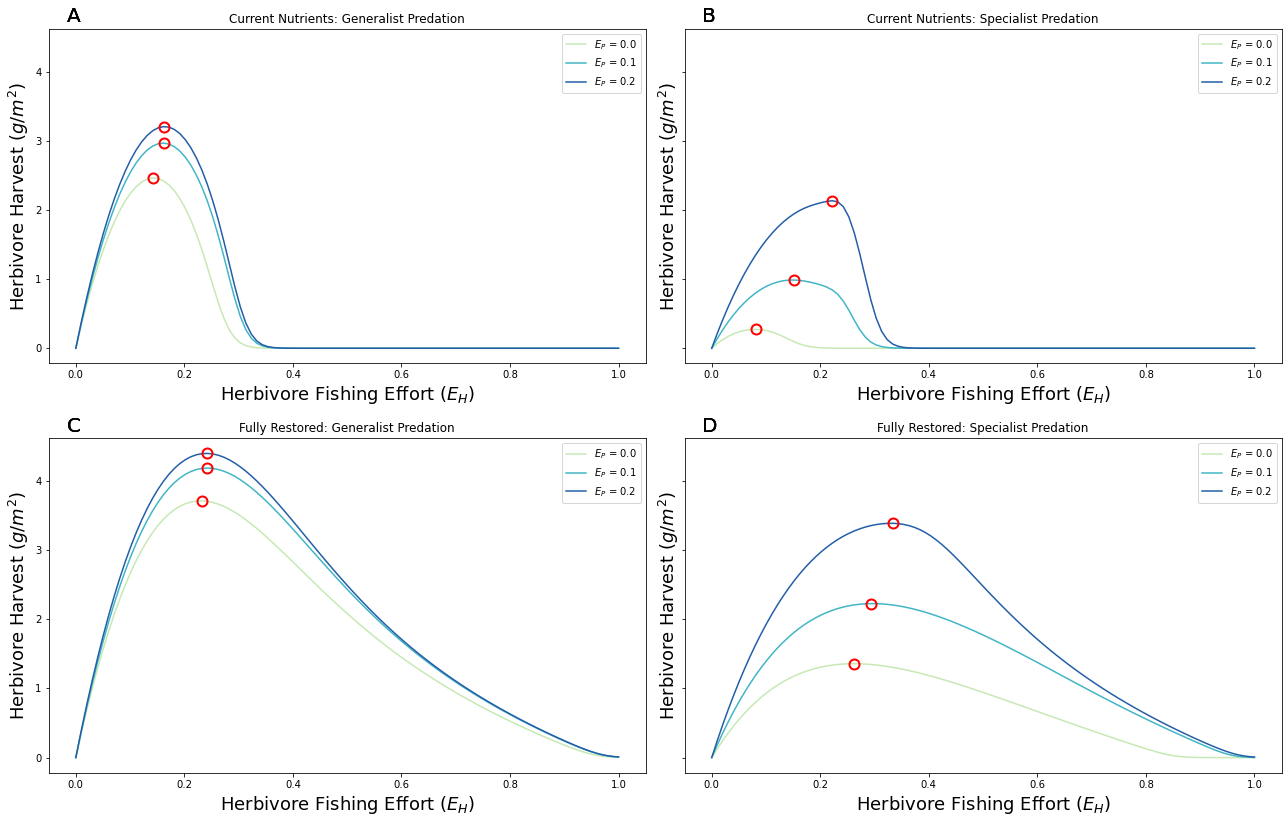

In [12]:
# Define the plotting function with maximum yield highlighting
def plot_harvest(E_H_array, H_harvest_final_array, E_P_values, title, ax, label):
    for idx, E_P in enumerate(E_P_values):
        y_values = H_harvest_final_array[idx] * 365
        ax.plot(E_H_array, y_values, label=f'$E_P$ = {E_P*365:.1f}', color=colors[idx])
        ax.text(0.03, 1.02, label, transform=ax.transAxes, fontsize=20)
        
        # Find the maximum value and its index
        max_idx = np.argmax(y_values)
        max_E_H = E_H_array[max_idx]
        max_value = y_values[max_idx]
        
        # Add a red circle around the maximum value
        ax.plot(max_E_H, max_value, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)
        
    ax.set_xlabel('Herbivore Fishing Effort ($E_H$)', fontsize = 18)
    ax.set_ylabel('Herbivore Harvest ($g/m^2$)', fontsize = 18)
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=12)

    
# Subplot 1: Generalist, Low Nutrients
N_pulse_value = 0.026
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]
size = 100
E_H_array = np.linspace(0, 1.0, size)
H_harvest_final_array = np.zeros((len(E_P_values), size))

# Set up the colorblind-friendly palette
colors = sns.color_palette("YlGnBu", n_colors=len(E_P_values))
    
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=True)
#fig.suptitle('Prey Harvest Curves for Generalist and Specialist Strategies with Varying Nutrient Levels', fontsize=20)

# Subplot 1: Generalist, Low Nutrients
#N_pulse_value = 0.026
#E_P_values = [(0.0/365), (0.1/365), (0.2/365)]
#size = 100
#E_H_array = np.linspace(0, 1.0, size)
#H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Current Nutrients: Generalist Predation', axes[0, 0], 'A')

# Subplot 2: Specialist, Low Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Current Nutrients: Specialist Predation', axes[0, 1], 'B')

# Subplot 3: Generalist, High Nutrients
N_pulse_value = 0.234
H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Fully Restored: Generalist Predation', axes[1, 0], 'C')

# Subplot 4: Specialist, High Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Fully Restored: Specialist Predation', axes[1, 1], 'D')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Predator curves

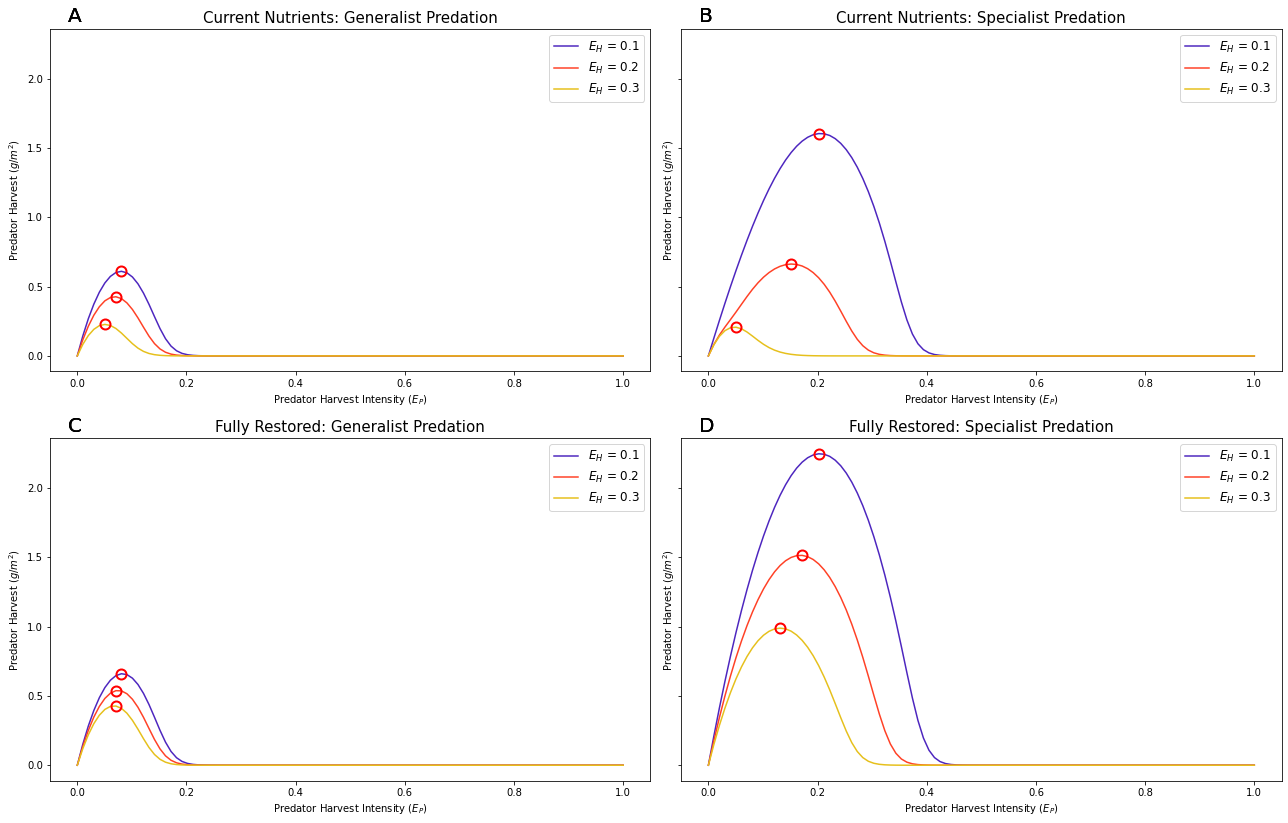

In [14]:
# Define the plotting function for predator harvest
def plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, title, ax, label):
    for idx, E_H in enumerate(E_H_values):
        y_values = P_harvest_final_array[idx] * 365
        ax.plot(E_P_array, P_harvest_final_array[idx]*365, label=f'$E_H$ = {E_H*365:.1f}', color=colors[idx])
        ax.text(0.03, 1.02, label, transform=ax.transAxes, fontsize=20)
        
        # Find the maximum value and its index
        max_idx = np.argmax(y_values)
        max_E_P = E_P_array[max_idx]
        max_value = y_values[max_idx]
        
        # Add a red circle around the maximum value
        ax.plot(max_E_P, max_value, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)
        
    ax.set_xlabel('Predator Harvest Intensity ($E_P$)', fontsize = 18)
    ax.set_ylabel('Predator Harvest ($g/m^2$)', fontsize = 18)
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=12)

    
# Set up the colorblind-friendly palette
colors = sns.color_palette("CMRmap", n_colors=len(E_P_values))

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=True)
#fig.suptitle('Predator Harvest Curves with Varying Herbivore Fishing Effort and Nutrient Levels', fontsize=20)

# Subplot 1: Generalist, Low Nutrients
E_H_values = [0.1/365, 0.2/365, 0.3/365]
N_pulse_value = 0.026
size = 100
E_P_array = np.linspace(0, 1.0, size)
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Current Nutrients: Generalist Predation', axes[0, 0], 'A')

# Subplot 2: Specialist, Low Nutrients
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Current Nutrients: Specialist Predation', axes[0, 1], 'B')

# Subplot 3: Generalist, High Nutrients
N_pulse_value = 0.234
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Fully Restored: Generalist Predation', axes[1, 0], 'C')

# Subplot 4: Specialist, High Nutrients
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Fully Restored: Specialist Predation', axes[1, 1], 'D')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Need to save 

In [22]:
def compute_harvest_data(E_H_array, E_P_values, N_pulse_value, params_func):
    size = len(E_H_array)
    harvest_final_array = np.zeros((len(E_P_values), size))

    for idx, E_P in enumerate(E_P_values):
        for i in range(size):
            E_H = E_H_array[i]
            parameters_dict = params_func()
            parameters_dict['E_H'] = E_H / 365
            parameters_dict['E_P'] = E_P
            parameters_dict['N_pulse'] = N_pulse_value  
            H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
            harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:])
    
    return harvest_final_array


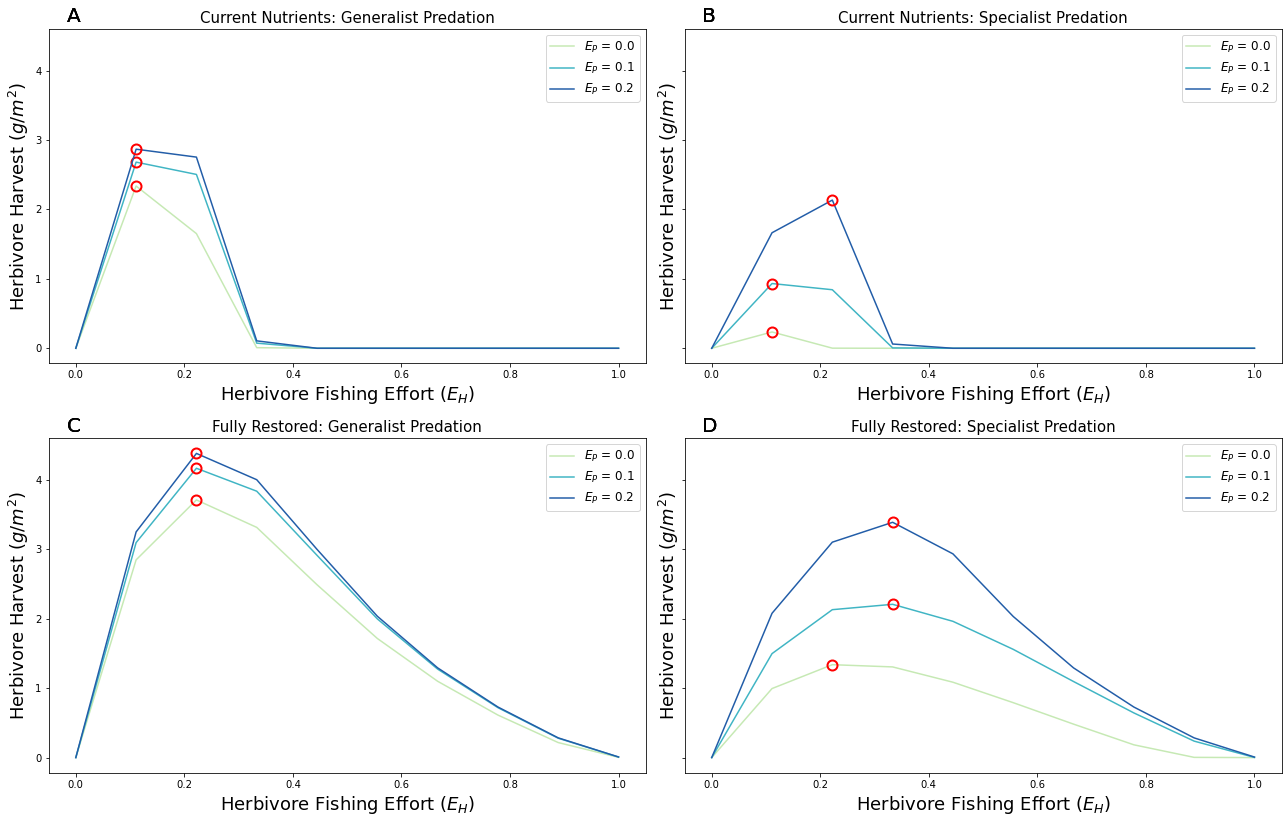

In [16]:
# Define the plotting function with maximum yield highlighting
def plot_harvest(E_H_array, harvest_final_array, E_P_values, title, ax, label):
    for idx, E_P in enumerate(E_P_values):
        y_values = harvest_final_array[idx] * 365
        ax.plot(E_H_array, y_values, label=f'$E_P$ = {E_P*365:.1f}', color=colors[idx])
        ax.text(0.03, 1.02, label, transform=ax.transAxes, fontsize=20)
        
        # Find the maximum value and its index
        max_idx = np.argmax(y_values)
        max_E_H = E_H_array[max_idx]
        max_value = y_values[max_idx]
        
        # Add a red circle around the maximum value
        ax.plot(max_E_H, max_value, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)
        
    ax.set_xlabel('Herbivore Fishing Effort ($E_H$)', fontsize = 18)
    ax.set_ylabel('Herbivore Harvest ($g/m^2$)', fontsize = 18)
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=12)

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=True)

# Set up the colorblind-friendly palette
colors = sns.color_palette("YlGnBu", n_colors=len(E_P_values))

# Define E_H_array and E_P_values
size = 10
E_H_array = np.linspace(0, 1.0, size)
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]

# Subplot 1: Generalist, Low Nutrients
N_pulse_value = 0.026
H_harvest_final_array = compute_harvest_data(E_H_array, E_P_values, N_pulse_value, default_generalist_params)
plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Current Nutrients: Generalist Predation', axes[0, 0], 'A')

# Subplot 2: Specialist, Low Nutrients
H_harvest_final_array = compute_harvest_data(E_H_array, E_P_values, N_pulse_value, default_specialist_params)
plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Current Nutrients: Specialist Predation', axes[0, 1], 'B')

# Subplot 3: Generalist, High Nutrients
N_pulse_value = 0.234
H_harvest_final_array = compute_harvest_data(E_H_array, E_P_values, N_pulse_value, default_generalist_params)
plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Fully Restored: Generalist Predation', axes[1, 0], 'C')

# Subplot 4: Specialist, High Nutrients
H_harvest_final_array = compute_harvest_data(E_H_array, E_P_values, N_pulse_value, default_specialist_params)
plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Fully Restored: Specialist Predation', axes[1, 1], 'D')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [17]:
# Compute and save the arrays to disk
H_harvest_generalist_low = compute_harvest_data(E_H_array, E_P_values, 0.026, default_generalist_params)
np.save('H_harvest_generalist_low.npy', H_harvest_generalist_low)

H_harvest_specialist_low = compute_harvest_data(E_H_array, E_P_values, 0.026, default_specialist_params)
np.save('H_harvest_specialist_low.npy', H_harvest_specialist_low)

H_harvest_generalist_high = compute_harvest_data(E_H_array, E_P_values, 0.234, default_generalist_params)
np.save('H_harvest_generalist_high.npy', H_harvest_generalist_high)

H_harvest_specialist_high = compute_harvest_data(E_H_array, E_P_values, 0.234, default_specialist_params)
np.save('H_harvest_specialist_high.npy', H_harvest_specialist_high)

In [31]:
H_harvest_generalist_low = np.load('data/H_harvest_generalist_low.npy')
H_harvest_specialist_low = np.load('data/H_harvest_specialist_low.npy')
H_harvest_generalist_high = np.load('data/H_harvest_generalist_high.npy')
H_harvest_specialist_high = np.load('data/H_harvest_specialist_high.npy')

KeyboardInterrupt: 

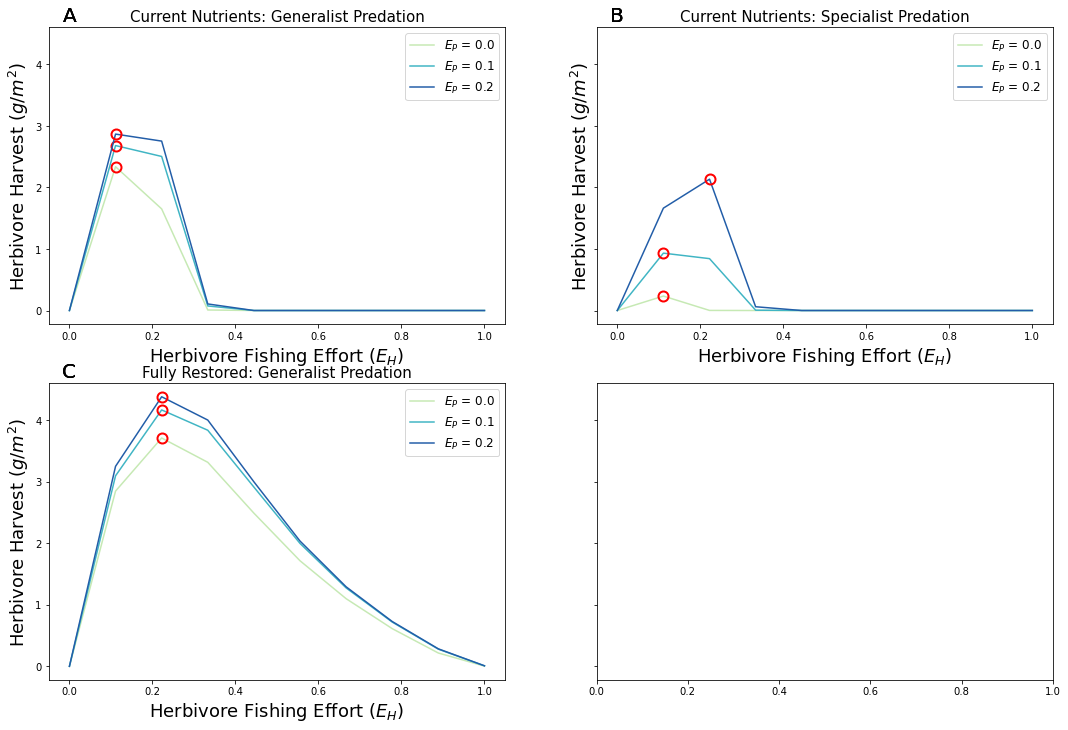

In [19]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=True)

# Set up the colorblind-friendly palette
colors = sns.color_palette("YlGnBu", n_colors=len(E_P_values))

# Define E_H_array and E_P_values
size = 10
E_H_array = np.linspace(0, 1.0, size)
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]

# Subplot 1: Generalist, Low Nutrients
N_pulse_value = 0.026
H_harvest_final_array = compute_harvest_data(E_H_array, E_P_values, N_pulse_value, default_generalist_params)
plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Current Nutrients: Generalist Predation', axes[0, 0], 'A')

# Subplot 2: Specialist, Low Nutrients
H_harvest_final_array = compute_harvest_data(E_H_array, E_P_values, N_pulse_value, default_specialist_params)
plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Current Nutrients: Specialist Predation', axes[0, 1], 'B')

# Subplot 3: Generalist, High Nutrients
N_pulse_value = 0.234
H_harvest_final_array = compute_harvest_data(E_H_array, E_P_values, N_pulse_value, default_generalist_params)
plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Fully Restored: Generalist Predation', axes[1, 0], 'C')

# Subplot 4: Specialist, High Nutrients
H_harvest_final_array = compute_harvest_data(E_H_array, E_P_values, N_pulse_value, default_specialist_params)
plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Fully Restored: Specialist Predation', axes[1, 1], 'D')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

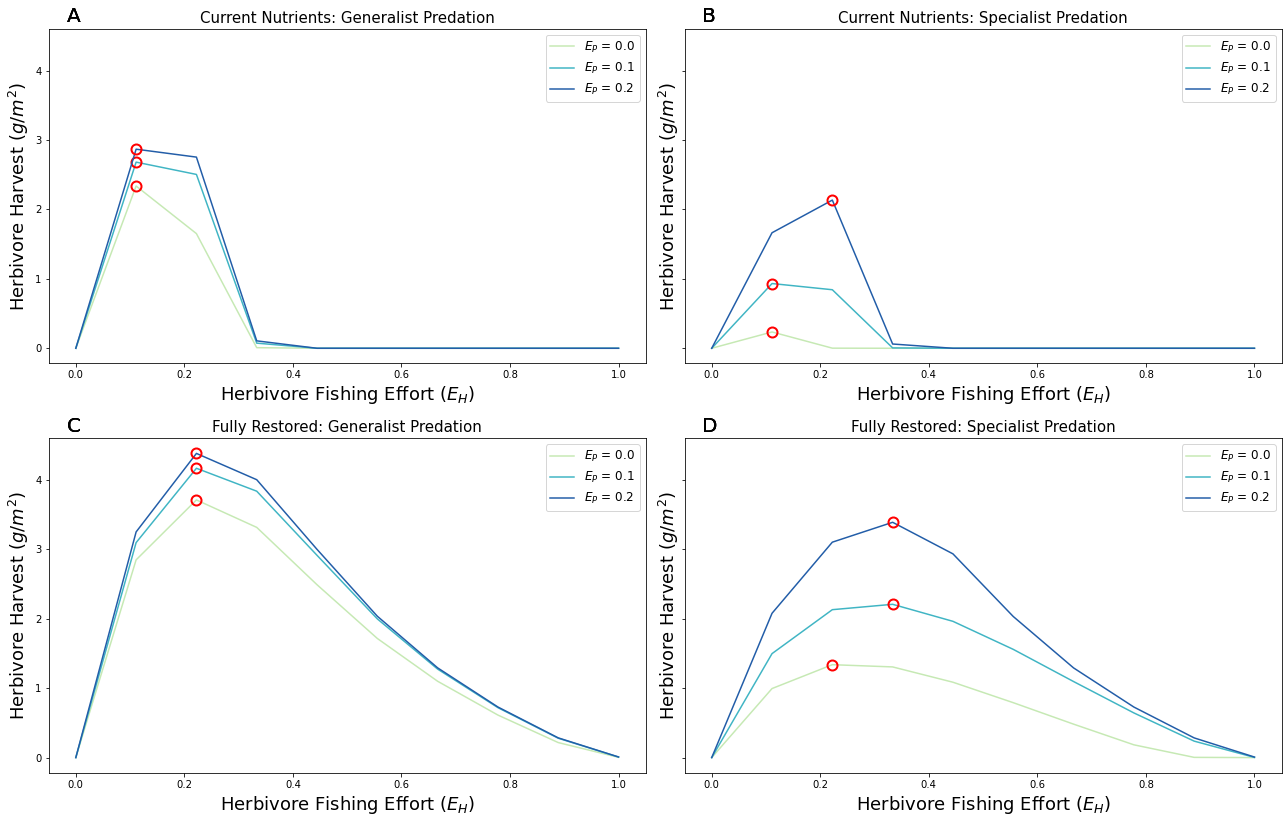

In [21]:
# Load the data
H_harvest_generalist_low = np.load('H_harvest_generalist_low.npy')
H_harvest_specialist_low = np.load('H_harvest_specialist_low.npy')
H_harvest_generalist_high = np.load('H_harvest_generalist_high.npy')
H_harvest_specialist_high = np.load('H_harvest_specialist_high.npy')

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=True)

# Set up the colorblind-friendly palette
colors = sns.color_palette("YlGnBu", n_colors=3)

# Define E_H_array and E_P_values
size = 100
E_H_array = np.linspace(0, 1.0, size)
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]

# Plot the data for each subplot
plot_harvest(E_H_array, H_harvest_generalist_low, E_P_values, 'Current Nutrients: Generalist Predation', axes[0, 0], 'A')
plot_harvest(E_H_array, H_harvest_specialist_low, E_P_values, 'Current Nutrients: Specialist Predation', axes[0, 1], 'B')
plot_harvest(E_H_array, H_harvest_generalist_high, E_P_values, 'Fully Restored: Generalist Predation', axes[1, 0], 'C')
plot_harvest(E_H_array, H_harvest_specialist_high, E_P_values, 'Fully Restored: Specialist Predation', axes[1, 1], 'D')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:
def compute_harvest_data(E_H_array, E_P_values, N_pulse_value, params_func, size=None):
    if size is None:
        size = len(E_H_array)
    
    harvest_final_array = np.zeros((len(E_P_values), size))

    for idx, E_P in enumerate(E_P_values):
        for i in range(size):
            E_H = E_H_array[i]
            parameters_dict = params_func()
            parameters_dict['E_H'] = E_H / 365
            parameters_dict['E_P'] = E_P
            parameters_dict['N_pulse'] = N_pulse_value  
            H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
            harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:])
    
    return harvest_final_array

In [12]:
# Define the plotting function with maximum yield highlighting
def plot_harvest(E_H_array, harvest_final_array, E_P_values, title, ax, label):
    for idx, E_P in enumerate(E_P_values):
        y_values = harvest_final_array[idx] * 365
        ax.plot(E_H_array, y_values, label=f'$E_P$ = {E_P*365:.1f}', color=colors[idx])
        ax.text(0.03, 1.02, label, transform=ax.transAxes, fontsize=20)
        
        # Find the maximum value and its index
        max_idx = np.argmax(y_values)
        max_E_H = E_H_array[max_idx]
        max_value = y_values[max_idx]
        
        # Add a red circle around the maximum value
        ax.plot(max_E_H, max_value, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)
        
    ax.set_xlabel('Herbivore Fishing Effort ($E_H$)', fontsize = 18)
    ax.set_ylabel('Herbivore Harvest ($g/m^2$)', fontsize = 18)
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=12)

In [15]:
size = 100
E_H_array = np.linspace(0, 1.0, size)
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]

# Compute and save the arrays to disk
H_harvest_generalist_low = compute_harvest_data(E_H_array, E_P_values, 0.026, default_generalist_params, 100)
np.save('H_harvest_generalist_low.npy', H_harvest_generalist_low)

H_harvest_specialist_low = compute_harvest_data(E_H_array, E_P_values, 0.026, default_specialist_params, 100)
np.save('H_harvest_specialist_low.npy', H_harvest_specialist_low)

H_harvest_generalist_high = compute_harvest_data(E_H_array, E_P_values, 0.234, default_generalist_params, 100)
np.save('H_harvest_generalist_high.npy', H_harvest_generalist_high)

H_harvest_specialist_high = compute_harvest_data(E_H_array, E_P_values, 0.234, default_specialist_params, 100)
np.save('H_harvest_specialist_high.npy', H_harvest_specialist_high)

KeyboardInterrupt: 

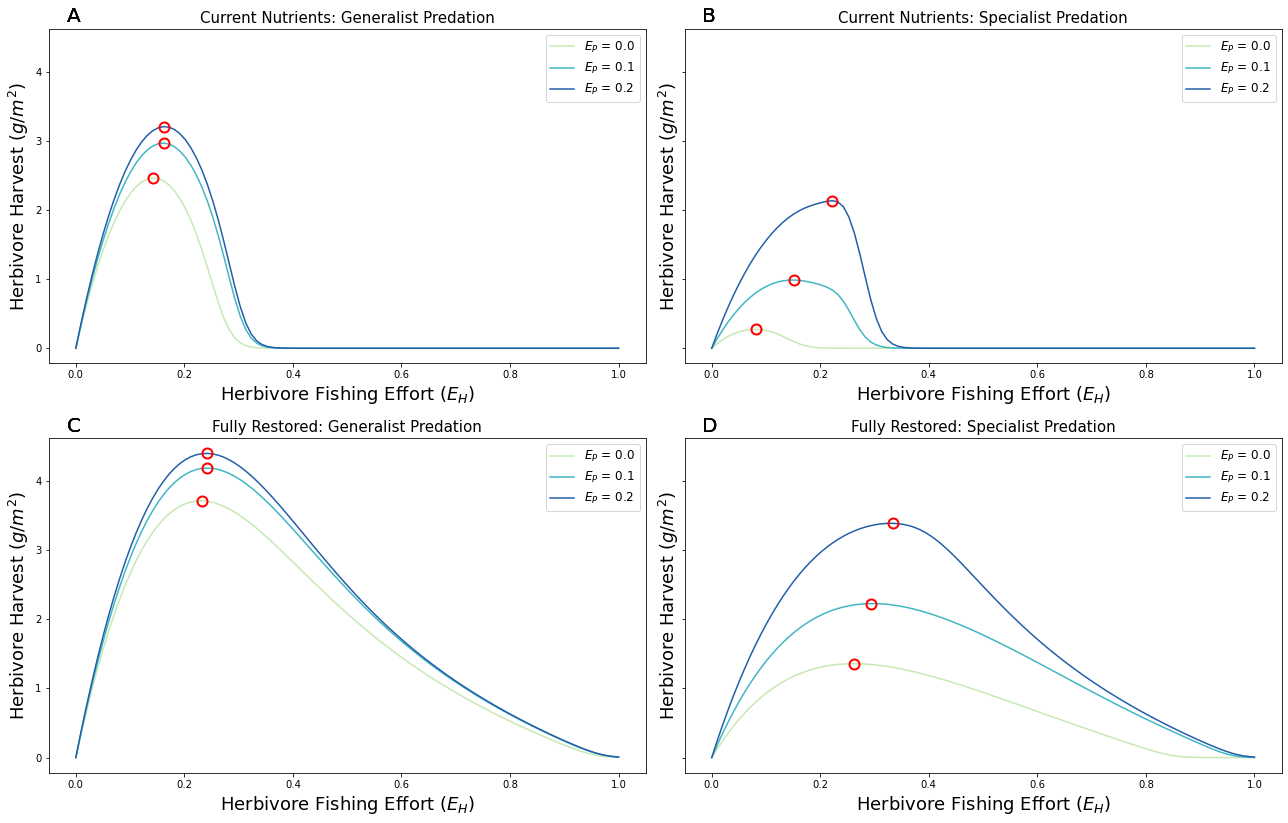

In [32]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=True)

# Set up the colorblind-friendly palette
colors = sns.color_palette("YlGnBu", n_colors=3)

# Define E_H_array and E_P_values
#size = 100
#E_H_array = np.linspace(0, 1.0, size)
#E_P_values = [(0.0/365), (0.1/365), (0.2/365)]

# Plot the data for each subplot
plot_harvest(E_H_array, H_harvest_generalist_low, E_P_values, 'Current Nutrients: Generalist Predation', axes[0, 0], 'A')
plot_harvest(E_H_array, H_harvest_specialist_low, E_P_values, 'Current Nutrients: Specialist Predation', axes[0, 1], 'B')
plot_harvest(E_H_array, H_harvest_generalist_high, E_P_values, 'Fully Restored: Generalist Predation', axes[1, 0], 'C')
plot_harvest(E_H_array, H_harvest_specialist_high, E_P_values, 'Fully Restored: Specialist Predation', axes[1, 1], 'D')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Same but with Pred

In [23]:
def compute_pred_harvest_data(E_P_array, E_H_values, N_pulse_value, params_func):
    size = len(E_P_array)
    pred_harvest_final_array = np.zeros((len(E_H_values), size))

    for idx, E_H in enumerate(E_H_values):
        for i in range(size):
            E_P = E_P_array[i]
            parameters_dict = params_func()
            parameters_dict['E_P'] = E_P / 365
            parameters_dict['E_H'] = E_H
            parameters_dict['N_pulse'] = N_pulse_value  
            H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
            pred_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:])
    
    return pred_harvest_final_array

In [24]:
size = 10
E_P_array = np.linspace(0, 1.0, size)
E_H_values = [(0.0/365), (0.1/365), (0.2/365)]

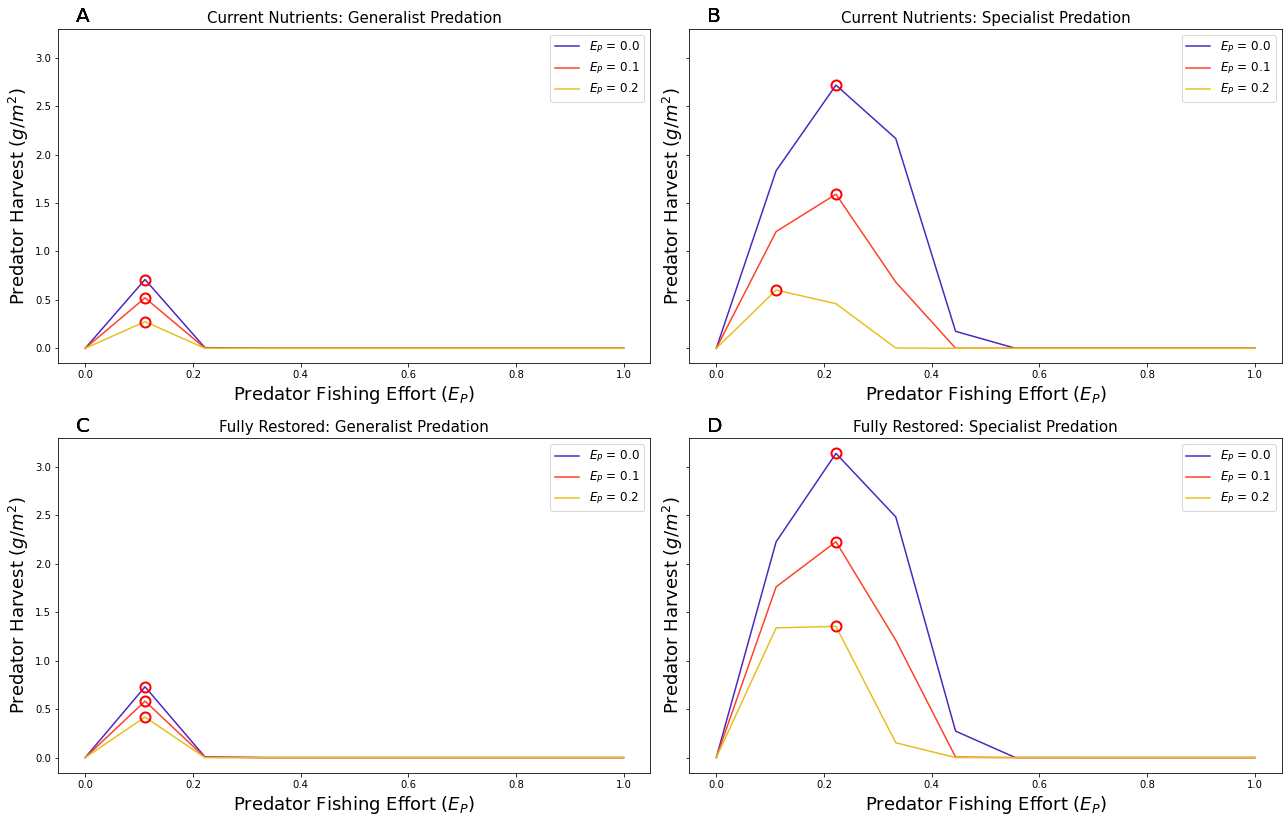

In [25]:
# Define the plotting function with maximum yield highlighting
def plot_pred_harvest(E_P_array, pred_harvest_final_array, E_H_values, title, ax, label):
    for idx, E_H in enumerate(E_H_values):
        y_values = pred_harvest_final_array[idx] * 365
        ax.plot(E_P_array, y_values, label=f'$E_P$ = {E_H*365:.1f}', color=colors[idx])
        ax.text(0.03, 1.02, label, transform=ax.transAxes, fontsize=20)
        
        # Find the maximum value and its index
        max_idx = np.argmax(y_values)
        max_E_P = E_P_array[max_idx]
        max_value = y_values[max_idx]
        
        # Add a red circle around the maximum value
        ax.plot(max_E_P, max_value, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)
        
    ax.set_xlabel('Predator Fishing Effort ($E_P$)', fontsize = 18)
    ax.set_ylabel('Predator Harvest ($g/m^2$)', fontsize = 18)
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=12)

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=True)

# Set up the colorblind-friendly palette
colors = sns.color_palette("CMRmap", n_colors=len(E_H_values))

# Define E_H_array and E_P_values
#size = 10
#E_P_array = np.linspace(0, 1.0, size)
#E_H_values = [(0.0/365), (0.1/365), (0.2/365)]

# Subplot 1: Generalist, Low Nutrients
N_pulse_value = 0.026
P_harvest_final_array = compute_pred_harvest_data(E_P_array, E_H_values, N_pulse_value, default_generalist_params)
plot_pred_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Current Nutrients: Generalist Predation', axes[0, 0], 'A')

# Subplot 2: Specialist, Low Nutrients
P_harvest_final_array = compute_pred_harvest_data(E_P_array, E_H_values, N_pulse_value, default_specialist_params)
plot_pred_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Current Nutrients: Specialist Predation', axes[0, 1], 'B')

# Subplot 3: Generalist, High Nutrients
N_pulse_value = 0.234
P_harvest_final_array = compute_pred_harvest_data(E_P_array, E_H_values, N_pulse_value, default_generalist_params)
plot_pred_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Fully Restored: Generalist Predation', axes[1, 0], 'C')

# Subplot 4: Specialist, High Nutrients
P_harvest_final_array = compute_pred_harvest_data(E_P_array, E_H_values, N_pulse_value, default_specialist_params)
plot_pred_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Fully Restored: Specialist Predation', axes[1, 1], 'D')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [27]:
size = 100
E_P_array = np.linspace(0, 1.0, size)
E_H_values = [(0.0/365), (0.1/365), (0.2/365)]

# Compute and save the arrays to disk
P_harvest_generalist_low = compute_pred_harvest_data(E_P_array, E_H_values, 0.026, default_generalist_params)
np.save('P_harvest_generalist_low.npy', P_harvest_generalist_low)

P_harvest_specialist_low = compute_pred_harvest_data(E_P_array, E_H_values, 0.026, default_specialist_params)
np.save('P_harvest_specialist_low.npy', P_harvest_specialist_low)

P_harvest_generalist_high = compute_pred_harvest_data(E_P_array, E_H_values, 0.234, default_generalist_params)
np.save('P_harvest_generalist_high.npy', P_harvest_generalist_high)

P_harvest_specialist_high = compute_pred_harvest_data(E_P_array, E_H_values, 0.234, default_specialist_params)
np.save('P_harvest_specialist_high.npy', P_harvest_specialist_high)

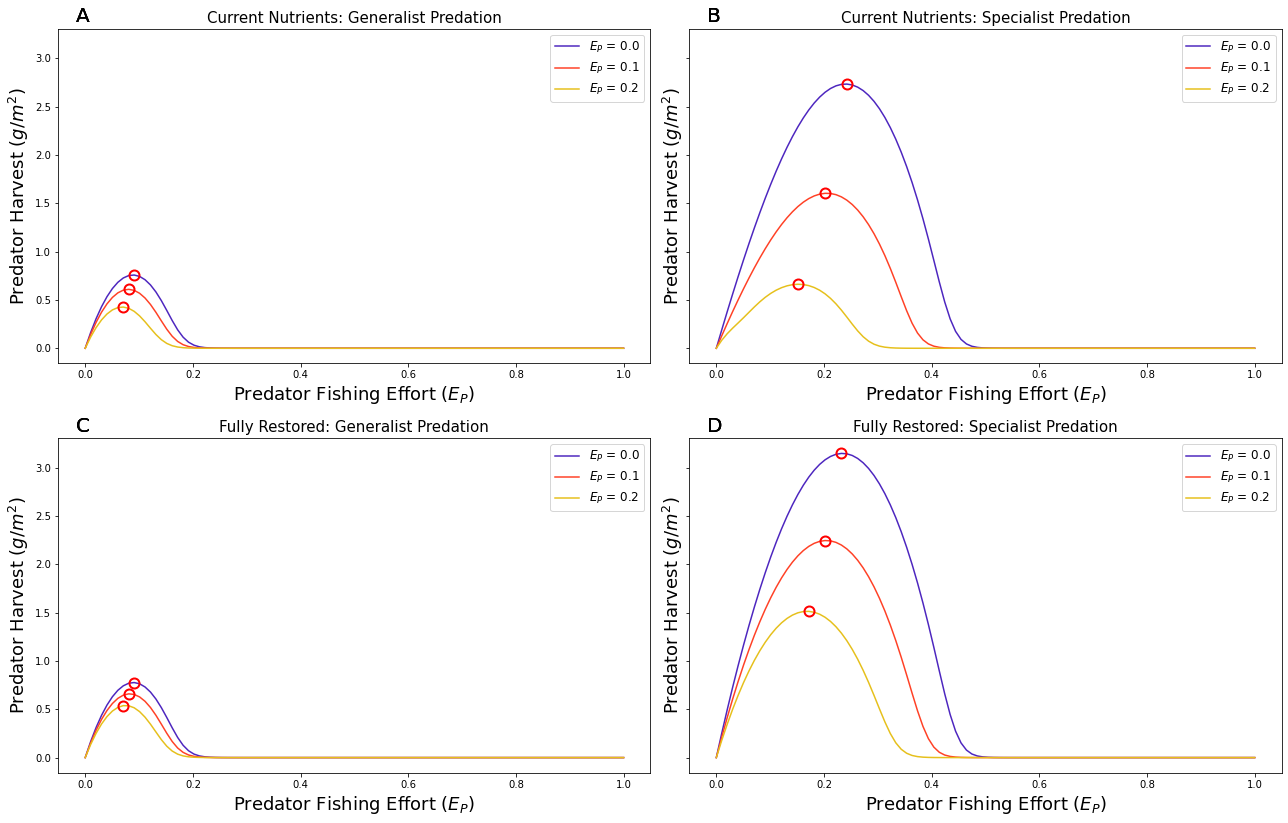

In [30]:
# Load the data
P_harvest_generalist_low = np.load('data/P_harvest_generalist_low.npy')
P_harvest_specialist_low = np.load('data/P_harvest_specialist_low.npy')
P_harvest_generalist_high = np.load('data/P_harvest_generalist_high.npy')
P_harvest_specialist_high = np.load('data/P_harvest_specialist_high.npy')

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=True)

# Set up the colorblind-friendly palette
colors = sns.color_palette("CMRmap", n_colors=3)

# Define E_H_array and E_P_values
#size = 100
#E_P_array = np.linspace(0, 1.0, size)
#E_H_values = [(0.0/365), (0.1/365), (0.2/365)]

# Plot the data for each subplot
plot_pred_harvest(E_P_array, P_harvest_generalist_low, E_H_values, 'Current Nutrients: Generalist Predation', axes[0, 0], 'A')
plot_pred_harvest(E_P_array, P_harvest_specialist_low, E_H_values, 'Current Nutrients: Specialist Predation', axes[0, 1], 'B')
plot_pred_harvest(E_P_array, P_harvest_generalist_high, E_H_values, 'Fully Restored: Generalist Predation', axes[1, 0], 'C')
plot_pred_harvest(E_P_array, P_harvest_specialist_high, E_H_values, 'Fully Restored: Specialist Predation', axes[1, 1], 'D')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()